# 1. Own Implementation

In [148]:
# imports
import numpy as np
import pandas as pd
#from scipy.special import expit  # Sigmoid

In [149]:
class NeuralNetwork:

    def __init__(self, input_size = 8, hidden1_size=100, hidden2_size = 50, output_size = 1, lr=0.1):
        
        # Learning rate
        self.lr = lr
        # Weights and biases
        # Input -> Hidden1
        self.w0 = np.random.randn(hidden1_size, input_size) * 0.01
        self.b0 = np.zeros((hidden1_size, 1))

        # # Hidden1 → hidden2
        self.w1 = np.random.randn(hidden2_size, hidden1_size) * 0.01
        self.b1 = np.zeros((hidden2_size, 1))

        # Hidden2 -> Output
        self.w2 = np.random.randn(output_size, hidden2_size) * 0.01
        self.b2 = np.zeros((output_size, 1))

        # Activation values
        self.a0 = None
        self.a1 = None
        self.a2 = None


    ### Activation functions    
    # Sigmoid 
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
        #return expit(x)  
    
    def sigmoid_deriv(self, a):
        return a * (1 - a) 
    
    # ReLU 
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_deriv(self, a):
        return (a > 0).astype(float)
    
    # Tanh
    def tanh(x):
        return np.tanh(x)

    def tanh_deriv(a):
        return 1 - a**2

    # Loss function
    # Binary Cross-Entropy 
    def loss(self, y_true, y_pred):
        epsilon = 1e-12  # avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon) 
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss

    def loss_deriv(self, y_true, y_pred):
        epsilon = 1e-12
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return (y_pred - y_true) / (y_pred * (1 - y_pred))

    def forward(self, X):

        self.X = X.T # X.T: (input_size, m)

        ### 1. Hidden Layer
        # z0 = W0 @ X_T + b0 
        # a0 = sig(z0)
        self.a0 = self.relu(self.w0 @ X.T + self.b0)
        
        ### 2. hidden layer 
        # z1 = W1 @ a0 + b1
        # a1 = sig(z1)
        self.a1 = self.relu(self.w1 @ self.a0 + self.b1)

        # output Layer
        self.a2 = self.sigmoid(self.w2 @ self.a1 + self.b2)
        
        return self.a2


    # Backward pass
    def backward(self, X, y_true):

        Y = y_true.T      # (output_size, m)
        m = Y.shape[1]    # samples

        y_true = y_true.T 

        ### OUTPUT LAYER
        # delta2 = self.a1 - y_true.T # optional this simple calculation
        delta2 = self.loss_deriv(Y, self.a2) * self.sigmoid_deriv(self.a2)

        # Gradients for w2, b2: 
        dw2 = (delta2 @ self.a1.T) / m  
        db2 = np.sum(delta2, axis=1, keepdims=True) / m

        ### HIDDEN LAYER 2
        # (weights output layer x error output layer) * derived activation 
        delta1 = (self.w2.T @ delta2) * self.relu_deriv(self.a1)

        # Gradients for w1, b1:
        # dw1: error in hidden layer 1 * outputs from hiddenlayer 2 (a2)
        dw1 = delta1 @ self.a0.T / m
        db1 = np.sum(delta1, axis=1, keepdims=True) / m # sum errors in current layer

        ### HIDDEN LAYER 1
        # Error back to the previous layer 
        delta0 = (self.w1.T @ delta1) * self.relu_deriv(self.a0)

        # Gradients for w0, b0: 
        dw0 = (delta0 @ self.X.T) / m 
        db0 = np.sum(delta0, axis=1, keepdims=True) / m

        # Update
        self.w2 -= self.lr * dw2
        self.b2 -= self.lr * db2
        self.w1 -= self.lr * dw1
        self.b1 -= self.lr * db1
        self.w0 -= self.lr * dw0
        self.b0 -= self.lr * db0


    def train(self, X, y):
        # Get the prediciton for current wheights
        y_pred = self.forward(X)

        # Compute the loss 
        current_loss = self.loss(y.T, y_pred)

        # Update the weights and biases
        self.backward(X, y)
        return current_loss


    def predict(self, X):
        a1 = self.forward(X)
        return a1.T



### Load and Prepare Data

In [150]:
# Load csv file with pandas
df = pd.read_csv('data/diabetes.csv')

# drop all na values
df = df.dropna()

In [151]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# one hot encoding of the target variable
X = df.drop('Outcome', axis=1).values  # shape: (n_samples, 8)
y = df['Outcome'].values.reshape(-1, 1)  # shape: (n_samples, 1)

# Skalieren der Eingabedaten
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(X_train.shape)  # (614, 8)
print(y_train.shape)  # (614, 1)


(614, 8)
(614, 1)


### Train the Network 

In [152]:
model = NeuralNetwork(input_size=8, hidden1_size=100, hidden2_size=50, output_size=1, lr=0.1)
# X_train: (n_samples, 784), y_train_oh: (n_samples, 10)
epochs = 100
losses = []
for epoch in range(epochs):
    loss = model.train(X_train, y_train)
    losses.append(loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")



Epoch 0: Loss = 0.6932
Epoch 10: Loss = 0.6745
Epoch 20: Loss = 0.6632
Epoch 30: Loss = 0.6564
Epoch 40: Loss = 0.6522
Epoch 50: Loss = 0.6497
Epoch 60: Loss = 0.6481
Epoch 70: Loss = 0.6471
Epoch 80: Loss = 0.6465
Epoch 90: Loss = 0.6461


In [153]:
tolerance = 1e-4   
patience = 200             
best_loss = float('inf')  
no_improvement = 0      
max_epochs = 10000

for epoch in range(max_epochs):
    loss = model.train(X_train, y_train)
    losses.append(loss)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

    #
    if best_loss - loss > tolerance:
        best_loss = loss
        no_improvement = 0
    else:
        no_improvement += 1

    # 
    if no_improvement >= patience:
        print(f"\n Stop after erpch: {epoch}. no decresment after {patience} epochs")
        break


Epoch 0: Loss = 0.6459
Epoch 1000: Loss = 0.4391
Epoch 2000: Loss = 0.3902
Epoch 3000: Loss = 0.3386
Epoch 4000: Loss = 0.2677
Epoch 5000: Loss = 0.1794
Epoch 6000: Loss = 0.1152
Epoch 7000: Loss = 0.0644
Epoch 8000: Loss = 0.0350
Epoch 9000: Loss = 0.0188


Accuracy: 0.6948


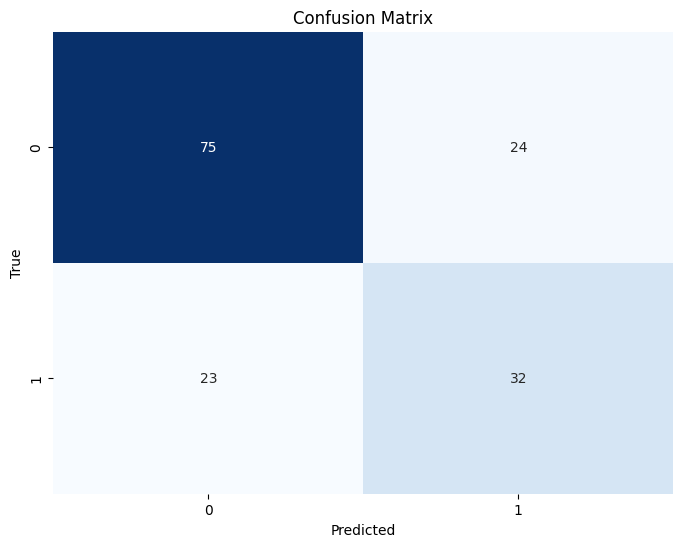

Confusion Matrix:
[[75 24]
 [23 32]]
Mean y_pred: 0.36386392691326314


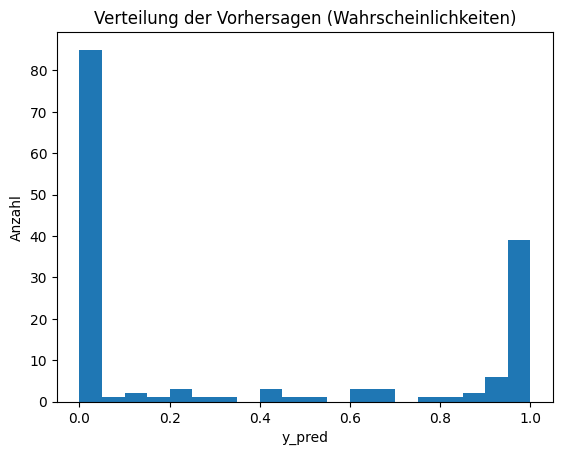

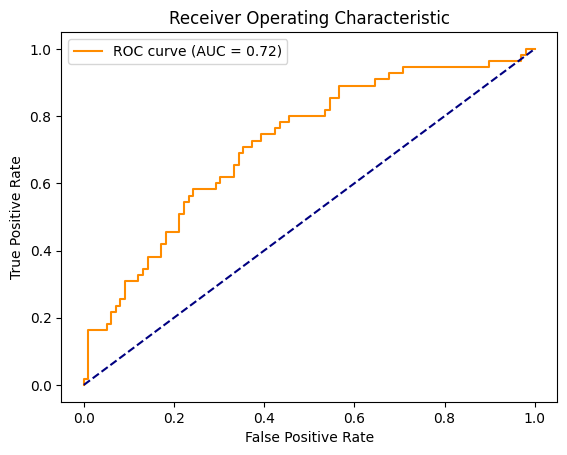

In [154]:
# Predict 
y_pred = model.predict(X_test)
# Convert predictions to binary with a threshold of 0.5
y_pred_binary = (y_pred >= 0.5).astype(int)
y_test_binary = y_test.astype(int)


# Calculate accuracy
accuracy = np.mean(y_pred_binary == y_test_binary)
print(f"Accuracy: {accuracy:.4f}")

# confussion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# print confusion matrix
print("Confusion Matrix:")
print(cm)

print("Mean y_pred:", np.mean(y_pred))


import matplotlib.pyplot as plt
plt.hist(y_pred, bins=20)
plt.title("Verteilung der Vorhersagen (Wahrscheinlichkeiten)")
plt.xlabel("y_pred")
plt.ylabel("Anzahl")
plt.show()


from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()


In [ ]:
def get_model_stats(model):
    import numpy as np

    arrays = [model.w0, model.b0, model.w1, model.b1, model.w2, model.b2]
    
    # number of paramters (all weights + biases)
    total_params = sum(arr.size for arr in arrays)

    # RAM
    total_bytes = sum(arr.nbytes for arr in arrays)
    total_MB = total_bytes / (1024 ** 2)

    print(f"Total learnable parameters: {total_params:,}")
    print(f"Actual memory usage: {total_MB:.2f} MB")

    return total_params, total_MB


get_model_stats(model)

Total learnable parameters: 6,001
Actual memory usage: 0.05 MB


(6001, 0.04578399658203125)

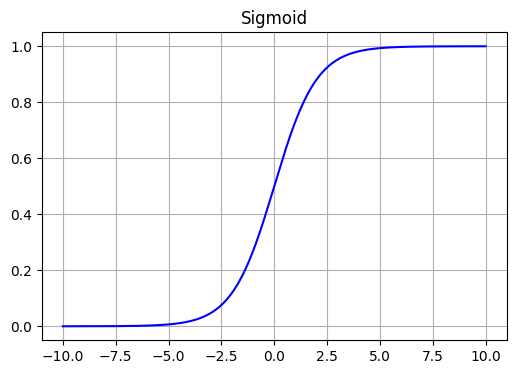

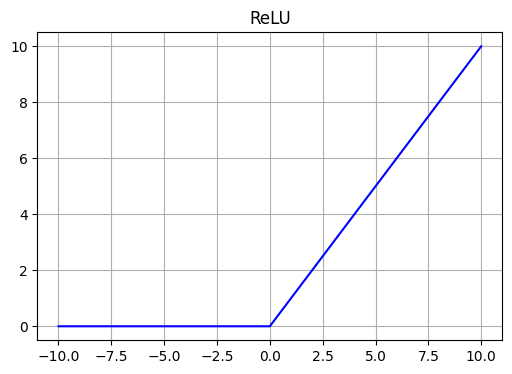

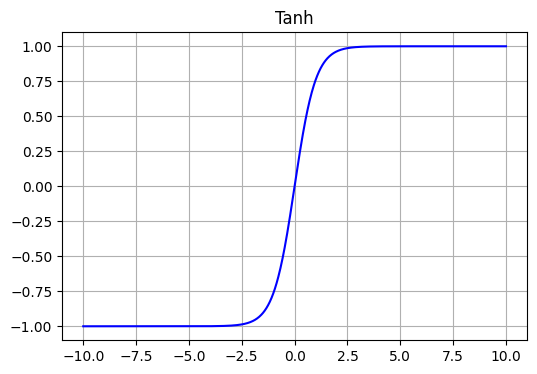

In [132]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

# Wertebereich
x = np.linspace(-10, 10, 1000)

# Auswerten der Funktionen
sig = sigmoid(x)

r = relu(x)

t = tanh(x)


# Einzelne Plots generieren
def plot_function(x, y, title, color='blue'):
    plt.figure(figsize=(6, 4))
    plt.plot(x, y, color=color)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Plotten
plot_function(x, sig, 'Sigmoid')

plot_function(x, r, 'ReLU')

plot_function(x, t, 'Tanh')


# 2. PyTorch 

**Sequential Model:**

https://medium.com/writeasilearn/using-sequential-module-to-build-a-neural-network-a34ca3f37203


In [138]:
# Data 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
import torch

# Features: float32
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch  = torch.tensor(X_test, dtype=torch.float32)

# Targets: float32 UND als Spaltenvektor (N, 1)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_torch  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


model = nn.Sequential(
    nn.Linear(8, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1),
    nn.Sigmoid()
)

# binary cross-entropy loss
criterion = nn.BCELoss() 

# Optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.01)
lr = 0.1

# Training loop
epochs = 1000
for epoch in range(epochs):
    model.train()

    # Forward-Pass
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)

    # Gradienten auf 0 setzen
    model.zero_grad()

    # Backward-Pass (clac gradients)
    loss.backward()

    # Update manuelly
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad

    # print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.6850
Epoch 100, Loss: 0.4583
Epoch 200, Loss: 0.4307
Epoch 300, Loss: 0.4162
Epoch 400, Loss: 0.4040
Epoch 500, Loss: 0.3928
Epoch 600, Loss: 0.3818
Epoch 700, Loss: 0.3709
Epoch 800, Loss: 0.3592
Epoch 900, Loss: 0.3469


Test Accuracy: 0.7143


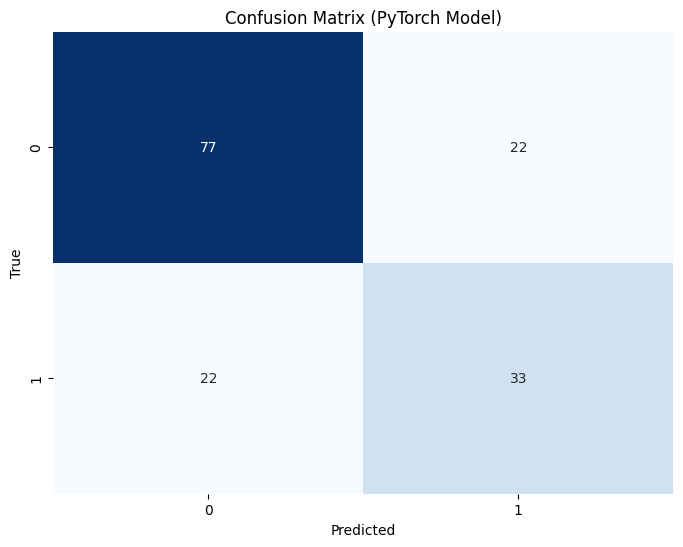

In [144]:
# Predict on test 
outputs_test = model(X_test_torch)
# Convert predictions to binary with a threshold of 0.5
y_pred_test = (outputs_test >= 0.5).float()
# Calculate accuracy
accuracy_test = (y_pred_test == y_test_torch).float().mean()
print(f"Test Accuracy: {accuracy_test:.4f}")
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test_torch.numpy(), y_pred_test.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (PyTorch Model)')
plt.show()


# LLM Implementation


Prompt: 
Implement a framework for neural networks (NN). Implement the entire network from scratch, including forward and backward propagation methods

In [114]:
import numpy as np

# Base class for layers
class Layer:
    def forward(self, input):
        raise NotImplementedError
        
    def backward(self, output_gradient, learning_rate):
        raise NotImplementedError

# Dense (fully connected) layer
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2. / input_size)
        self.bias = np.zeros((1, output_size))

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(self.input.T, output_gradient)
        input_gradient = np.dot(output_gradient, self.weights.T)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * np.mean(output_gradient, axis=0, keepdims=True)
        return input_gradient

# Activation functions
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(input)

    def backward(self, output_gradient, learning_rate):
        return self.activation_prime(self.input) * output_gradient

# Specific activation functions
def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    s = sigmoid(x)
    return s * (1 - s)

# Loss function
class MeanSquaredError:
    def loss(self, predicted, actual):
        return np.mean(np.power(predicted - actual, 2))

    def gradient(self, predicted, actual):
        return 2 * (predicted - actual) / actual.size

# Neural network class
class NeuralNetwork2:
    def __init__(self):
        self.layers = []
        self.loss_fn = MeanSquaredError()

    def add(self, layer):
        self.layers.append(layer)

    def predict(self, x):
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def train(self, x_train, y_train, epochs, learning_rate):
        for epoch in range(epochs):
            output = self.predict(x_train)
            loss = self.loss_fn.loss(output, y_train)
            grad = self.loss_fn.gradient(output, y_train)
            
            for layer in reversed(self.layers):
                grad = layer.backward(grad, learning_rate)
            
            if (epoch + 1) % 100 == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

In [ ]:
nn = NeuralNetwork2()
nn.add(Dense(8, 4))
nn.add(Activation(relu, relu_prime))
nn.add(Dense(4, 1))
nn.add(Activation(sigmoid, sigmoid_prime))


nn.train(X_train, y_train, epochs=1000, learning_rate=0.1)

# Predictions
preds = nn.predict(X_train)
print("Predictions:")
print(preds)

pred_classes = (preds >= 0.5).astype(int)

true_classes = y_train.reshape(-1, 1)

# Accuracy 
accuracy = np.mean(pred_classes == true_classes)
print(f"Accuracy: {accuracy:.4f}")


Epoch 1, Loss: 0.2819
Epoch 100, Loss: 0.2229
Epoch 200, Loss: 0.2069
Epoch 300, Loss: 0.1909
Epoch 400, Loss: 0.1773
Epoch 500, Loss: 0.1684
Epoch 600, Loss: 0.1627
Epoch 700, Loss: 0.1589
Epoch 800, Loss: 0.1560
Epoch 900, Loss: 0.1537
Epoch 1000, Loss: 0.1521
Predictions:
[[5.07946905e-03]
 [5.36302217e-01]
 [5.26832140e-01]
 [4.67194773e-01]
 [5.08737611e-01]
 [2.12597748e-01]
 [4.75399703e-01]
 [6.40076316e-01]
 [1.59568753e-01]
 [1.33779620e-02]
 [1.00617473e-01]
 [8.76415096e-01]
 [4.22706151e-02]
 [4.52085519e-01]
 [7.53171779e-01]
 [7.16236449e-01]
 [6.15975167e-01]
 [2.04708540e-01]
 [4.78460628e-01]
 [7.49919896e-01]
 [5.64381196e-01]
 [7.43535770e-02]
 [4.33788402e-01]
 [3.77232181e-01]
 [3.38277277e-01]
 [1.60980396e-01]
 [4.98654887e-01]
 [5.80813249e-01]
 [4.98654887e-01]
 [8.26282577e-01]
 [7.77118036e-01]
 [6.02053890e-02]
 [3.67297297e-02]
 [1.61541262e-01]
 [7.15099916e-01]
 [6.02217137e-01]
 [6.26597285e-02]
 [1.27894634e-01]
 [8.45481864e-01]
 [3.86900865e-01]
 [4.